In [1]:
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

In [2]:
# ฟังก์ชันตรวจจับ Drip และคำนวณจำนวนชั่วโมงไปถึงจุดต่ำสุด
def detect_drip_with_hours_to_low(data, window=12, threshold=-0.05):
    drips = []
    for i in range(len(data) - window):
        if drips and (data.index[i] - drips[-1]['start_time']).total_seconds() / 3600 < window:
            continue  # ข้ามถ้า Drip ใหม่เริ่มภายใน 12 ชั่วโมงจาก Drip ก่อนหน้า
        
        close_price = data['close'].iloc[i]
        low_price = data['low'].iloc[i:i+window].min()
        drip_pct = (low_price - close_price) / close_price
        if drip_pct <= threshold:
            # หา index และเวลาของ Low
            low_idx = data['low'].iloc[i:i+window].idxmin()
            low_time = low_idx
            start_time = data.index[i]
            # คำนวณจำนวนชั่วโมงจาก start_time ถึง low_time
            hours_to_low = (low_time - start_time).total_seconds() / 3600
            drips.append({
                'start_time': start_time,
                'low_time': low_time,
                'close_price': close_price,
                'low_price': low_price,
                'drip_pct': drip_pct * 100,
                'hours_to_low': hours_to_low,
                'month': start_time.month
            })
            # ข้าม 12 ชั่วโมงเพื่อลด Overlap
            i += window - 1
    return pd.DataFrame(drips)

In [3]:
data = pd.read_pickle(os.path.abspath("../../crypto/datasets/preprocessed/BTCUSDT/1h/features.pkl"))
#data = data["2024-01-01":"2024-12-31"]

# ตรวจจับ Drip และบันทึกจำนวนชั่วโมง
drips = detect_drip_with_hours_to_low(data)

In [4]:
# 1. การแจกแจงของจำนวนชั่วโมงไปถึงจุดต่ำสุด
print("\nSummary of Hours to Reach Drip Low:")
hours_summary = {
    'Number of Drips': len(drips),
    'Mean Hours': drips['hours_to_low'].mean(),
    'Std Hours': drips['hours_to_low'].std(),
    'Min Hours': drips['hours_to_low'].min(),
    'Max Hours': drips['hours_to_low'].max(),
    'Median Hours': drips['hours_to_low'].median()
}
for key, value in hours_summary.items():
    print(f"{key}: {value:.2f}")


Summary of Hours to Reach Drip Low:
Number of Drips: 710.00
Mean Hours: 8.48
Std Hours: 3.57
Min Hours: 0.00
Max Hours: 18.00
Median Hours: 10.00


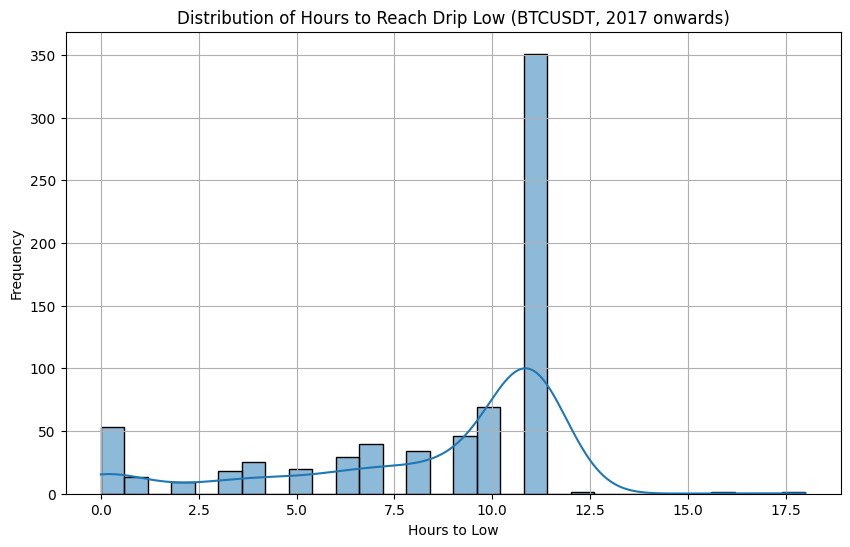

In [5]:
# สร้างฮิสโตแกรมของจำนวนชั่วโมง
plt.figure(figsize=(10, 6))
sns.histplot(drips['hours_to_low'].dropna(), bins=30, kde=True)
plt.title('Distribution of Hours to Reach Drip Low (BTCUSDT, 2017 onwards)')
plt.xlabel('Hours to Low')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [6]:
# ทดสอบความปกติของจำนวนชั่วโมง (Shapiro-Wilk Test)
stat, p_value = stats.shapiro(drips['hours_to_low'].dropna())
print(f"\nShapiro-Wilk Test for Hours Normality: stat={stat:.4f}, p-value={p_value:.4f}")
if p_value < 0.05:
    print("Hours distribution is not normal (p < 0.05)")
else:
    print("Hours distribution is normal (p >= 0.05)")


Shapiro-Wilk Test for Hours Normality: stat=0.7489, p-value=0.0000
Hours distribution is not normal (p < 0.05)


In [7]:
# 2. ค่าเฉลี่ยจำนวนชั่วโมงตามเดือน
monthly_hours_means = drips.groupby('month')['hours_to_low'].mean().reset_index()
monthly_hours_means.columns = ['Month', 'Mean Hours to Low']
print("\nMean Hours to Reach Drip Low by Month:")
print(monthly_hours_means.round(2))


Mean Hours to Reach Drip Low by Month:
    Month  Mean Hours to Low
0       1               8.16
1       2               8.53
2       3               8.87
3       4               8.74
4       5               8.99
5       6               8.89
6       7               8.42
7       8               8.83
8       9               9.29
9      10               7.56
10     11               8.35
11     12               7.34


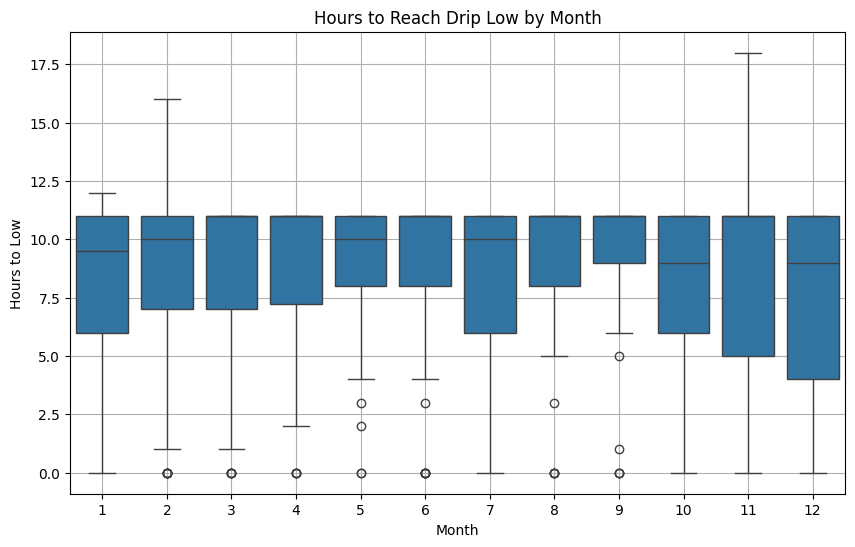

In [8]:
# สร้าง Boxplot เพื่อแสดงการกระจายของจำนวนชั่วโมงตามเดือน
plt.figure(figsize=(10, 6))
sns.boxplot(x='month', y='hours_to_low', data=drips)
plt.title('Hours to Reach Drip Low by Month')
plt.xlabel('Month')
plt.ylabel('Hours to Low')
plt.grid(True)
plt.show()

In [9]:
# 3. One-Way ANOVA Test: เปรียบเทียบค่าเฉลี่ยจำนวนชั่วโมงระหว่างเดือน
if len(drips['month'].unique()) > 2:
    groups = [drips[drips['month'] == month]['hours_to_low'].dropna() for month in drips['month'].unique()]
    f_stat, p_value = stats.f_oneway(*groups)
    print(f"\nOne-Way ANOVA Test for Hours to Low: F={f_stat:.4f}, p-value={p_value:.4f}")
    if p_value < 0.05:
        print("Significant difference in mean Hours to Low between months (p < 0.05)")
    else:
        print("No significant difference in mean Hours to Low between months (p >= 0.05)")
else:
    print("\nANOVA Test: Not enough months to perform the test.")


One-Way ANOVA Test for Hours to Low: F=1.5978, p-value=0.0947
No significant difference in mean Hours to Low between months (p >= 0.05)


In [10]:
# 4. T-Test: เปรียบเทียบค่าเฉลี่ยจำนวนชั่วโมงระหว่างคู่เดือน
print("\nT-Test Results for Hours to Low (p-values for pairwise comparisons):")
t_test_results = []
month_pairs = list(itertools.combinations(drips['month'].unique(), 2))
for month1, month2 in month_pairs:
    group1 = drips[drips['month'] == month1]['hours_to_low'].dropna()
    group2 = drips[drips['month'] == month2]['hours_to_low'].dropna()
    if len(group1) > 1 and len(group2) > 1:
        t_stat, p_value = stats.ttest_ind(group1, group2)
        t_test_results.append({
            'Month Pair': f'{month1} vs {month2}',
            'T-Statistic': t_stat,
            'P-Value': p_value
        })
t_test_df = pd.DataFrame(t_test_results)
print(t_test_df.round(4))


T-Test Results for Hours to Low (p-values for pairwise comparisons):
   Month Pair  T-Statistic  P-Value
0      8 vs 9      -0.6777   0.4997
1     8 vs 10       1.3857   0.1707
2     8 vs 11       0.6106   0.5428
3     8 vs 12       2.0036   0.0473
4      8 vs 1       1.0835   0.2805
..        ...          ...      ...
61     4 vs 6      -0.2160   0.8294
62     4 vs 7       0.3957   0.6934
63     5 vs 6       0.1705   0.8649
64     5 vs 7       0.8736   0.3845
65     6 vs 7       0.6269   0.5322

[66 rows x 3 columns]


In [11]:
# 5. Tukey’s HSD Test: เปรียบเทียบค่าเฉลี่ยจำนวนชั่วโมงระหว่างทุกเดือน
if len(drips['month'].unique()) > 2:
    tukey = pairwise_tukeyhsd(endog=drips['hours_to_low'].dropna(), groups=drips['month'], alpha=0.05)
    print("\nTukey’s HSD Test Results for Hours to Low:")
    print(tukey.summary())
else:
    print("\nTukey’s HSD Test: Not enough months to perform the test.")


Tukey’s HSD Test Results for Hours to Low:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   0.3741    1.0 -1.4892 2.2373  False
     1      3   0.7122 0.9784 -1.0769 2.5013  False
     1      4   0.5829  0.999 -1.5066 2.6724  False
     1      5   0.8288 0.9494 -1.0261 2.6838  False
     1      6   0.7326 0.9824 -1.1567  2.622  False
     1      7    0.268    1.0 -2.0833 2.6193  False
     1      8    0.673 0.9974 -1.5009 2.8469  False
     1      9   1.1379 0.7906 -0.8812 3.1569  False
     1     10  -0.5963 0.9999 -3.2126 2.0201  False
     1     11    0.193    1.0 -1.6964 2.0823  False
     1     12  -0.8189 0.9297 -2.5654 0.9276  False
     2      3   0.3381    1.0 -1.6224 2.2987  False
     2      4   0.2088    1.0 -2.0292 2.4469  False
     2      5   0.4548 0.9999 -1.5661 2.4756  False
     2      6   0.3586    1.0 -1.6938  2.411  False
     2      7  -0.10

In [12]:
# 6. F-Test: เปรียบเทียบความแปรปรวนของจำนวนชั่วโมงระหว่างคู่เดือน
print("\nF-Test Results for Hours to Low Variance:")
f_test_results = []
for month1, month2 in month_pairs:
    group1 = drips[drips['month'] == month1]['hours_to_low'].dropna()
    group2 = drips[drips['month'] == month2]['hours_to_low'].dropna()
    if len(group1) > 1 and len(group2) > 1:
        var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
        f_stat = var1 / var2 if var1 > var2 else var2 / var1
        df1, df2 = len(group1) - 1, len(group2) - 1
        p_value = 1 - stats.f.cdf(f_stat, df1, df2)
        f_test_results.append({
            'Month Pair': f'{month1} vs {month2}',
            'F-Statistic': f_stat,
            'P-Value': p_value
        })
f_test_df = pd.DataFrame(f_test_results)
print(f_test_df.round(4))


F-Test Results for Hours to Low Variance:
   Month Pair  F-Statistic  P-Value
0      8 vs 9       1.2428   0.2315
1     8 vs 10       1.2302   0.2991
2     8 vs 11       1.4607   0.0886
3     8 vs 12       1.3995   0.1003
4      8 vs 1       1.1209   0.3207
..        ...          ...      ...
61     4 vs 6       1.0550   0.4178
62     4 vs 7       1.2254   0.2760
63     5 vs 6       1.5013   0.0541
64     5 vs 7       1.2926   0.2149
65     6 vs 7       1.1614   0.3276

[66 rows x 3 columns]


In [13]:
# 7. Levene’s Test: เปรียบเทียบความแปรปรวนของจำนวนชั่วโมงระหว่างทุกเดือน
if len(drips['month'].unique()) > 2:
    groups = [drips[drips['month'] == month]['hours_to_low'].dropna() for month in drips['month'].unique()]
    stat, p_value = stats.levene(*groups)
    print(f"\nLevene’s Test for Hours to Low Variance: stat={stat:.4f}, p-value={p_value:.4f}")
    if p_value < 0.05:
        print("Variances are significantly different (p < 0.05)")
    else:
        print("No significant difference in variances (p >= 0.05)")
else:
    print("\nLevene’s Test: Not enough months to perform the test.")


Levene’s Test for Hours to Low Variance: stat=1.4780, p-value=0.1348
No significant difference in variances (p >= 0.05)
